<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

### Building the models


In [2]:
# building a model including a Simpson's paradox
def fillWithUniform(p,fmin=None,fmax=None):
  if fmin is None:
    vmin=0    
  if fmax is None:
    vmax=p.variable(0).domainSize()-1
    
  mi=int(p.variable(0).numerical(0))
  ma=int(p.variable(0).numerical(p.variable(0).domainSize()-1))
  
  p.fillWith(0)
  
  I=gum.Instantiation(p)

  I.setFirst()
  while not I.end():
    vars={p.variable(i).name():p.variable(i).numerical(I.val(i)) for i in range(1,p.nbrDim())}
    if fmin is not None:
      vmin=int(eval(fmin,None,vars))
    if fmax is not None:
      vmax=int(eval(fmax,None,vars))
    if vmin<mi:
      vmin=mi
    if vmin>ma:
      vmin=ma
    if vmax<mi:
      vmax=mi
    if vmax>ma:
      vmax=ma
    
    for pos in range(vmin,vmax+1):
      I.chgVal(0,pos)
      p.set(I,1)
    I.incNotVar(p.variable(0))
  p.normalizeAsCPT()
  
size=70
sizeZ=5
bn=gum.fastBN(f"A[0,{size-1}]->B[0,{size-1}]<-C[0,{sizeZ-1}]->A")

bn.cpt("C").fillWith(1).normalize()
fillWithUniform(bn.cpt("A"),fmin="C*12",fmax="C*12+30")
bn.cpt("B").fillWithFunction("5+C*4-int(A/8)",[0.05,0.2,0.5,0.2,0.05]);

In [3]:
#  generating a CSV, taking this model as the causal one.
gum.generateCSV(bn,"out/sample.csv",400)
df=pd.read_csv("out/sample.csv")

cm=csl.CausalModel(bn)
_,p,_=csl.causalImpact(cm,on="B",doing="A")

In [4]:
# building an Markov-equivalent model, generating a CSV, taking this model as the causal one.
bn2=gum.BayesNet(bn)
bn2.reverseArc("C","A")

gum.generateCSV(bn2,"out/sample2.csv",400)
df2=pd.read_csv("out/sample2.csv")

cm2=csl.CausalModel(bn2)
_,p2,_=csl.causalImpact(cm2,on="B",doing="A")

### The observationnal model and its paradoxal structure (exactly the same with the second Markov-equivalent model)


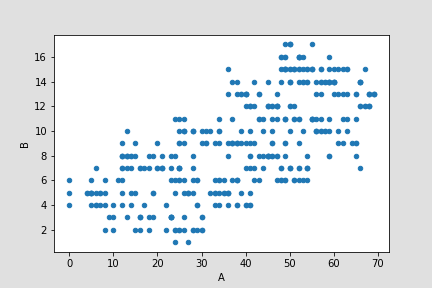
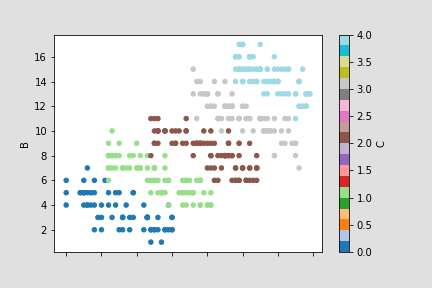


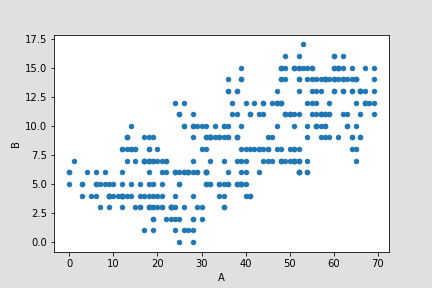
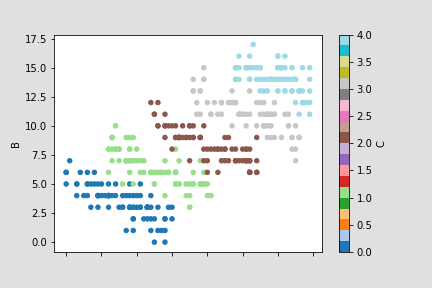

In [5]:
gnb.flow.row(gnb.getBN(bn),
             df.plot.scatter(x='A', y='B'),
             df.plot.scatter(x='A', y='B', c='C',colormap="tab20"),
             captions=["the observationnal model","the trend is increasing","the trend is decreasing for any value for C !"])
gnb.flow.row(gnb.getBN(bn2),
             df2.plot.scatter(x='A', y='B'),
             df2.plot.scatter(x='A', y='B', c='C',colormap="tab20"),
             captions=["the Markov-equivalent model","the trend is increasing","the trend is decreasing for any value for C !"])

### The paradox is revealed in the trend of the inferred means : the means are increasing with the value of $A$ **except for any value of $C$** ...


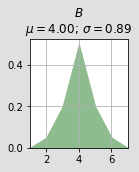
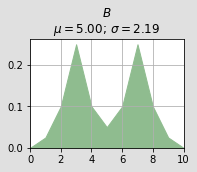
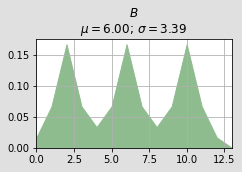
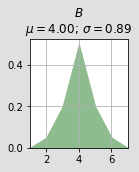
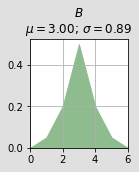
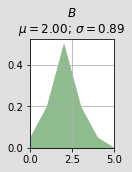
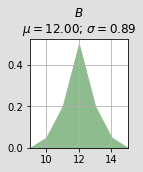
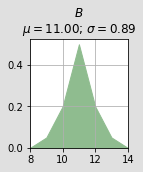
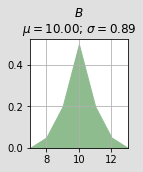
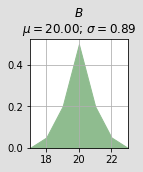
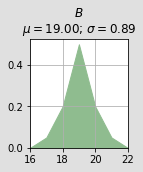
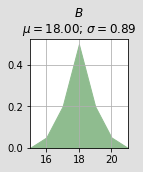

In [6]:
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":v}),f"$P(B|A={v})$")
gnb.flow.new_line()
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":v,"C":0}),f"P(B | $A={v},C=0)$")
gnb.flow.add_separator(10)
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":v,"C":2}),f"P(B | $A={v},C=2$)")
gnb.flow.add_separator(10)
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":v,"C":4}),f"P(B | $A={v},C=4$)")
gnb.flow.display()

### Now that the paradoxal structure is understood and the paradox is revealed, will we choose to observe $C$ (or not) before deciding to increase or decrease $A$ (with the goal to maximize $B$) ?

Of course, it depends on the causal structure of the problem !


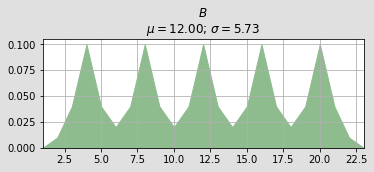
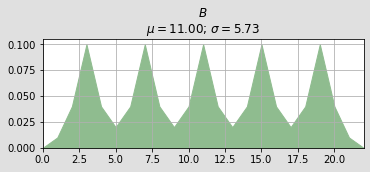
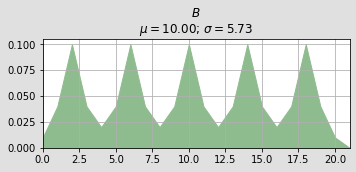

In [7]:
gnb.flow.add_html(cslnb.getCausalModel(cm),"the first causal model")
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getProba(p.extract({'A':v})),f"Doing $A={v}$")
gnb.flow.display()

### If $C$ is cause for $A$, observing $C$ really gives a new information about $B$.


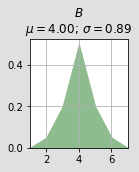
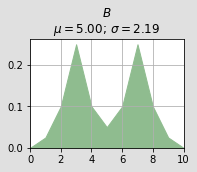
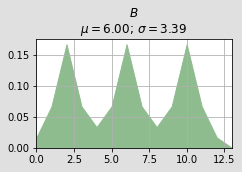

In [8]:
gnb.flow.add_html(cslnb.getCausalModel(cm2),"the second causal model")
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getProba(p2.extract({'A':v})),f"Doing $A={v}$")
gnb.flow.display()

### if $A$ is cause for $C$, observing $C$ may lead to misinterpretations about the causal role of $A$.